In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import pickle as pkl
from datasets.dataset import *
import matplotlib.pyplot as plt
import matplotlib

#### quick image view

In [8]:
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [9]:
i = 43

Current frame:  44


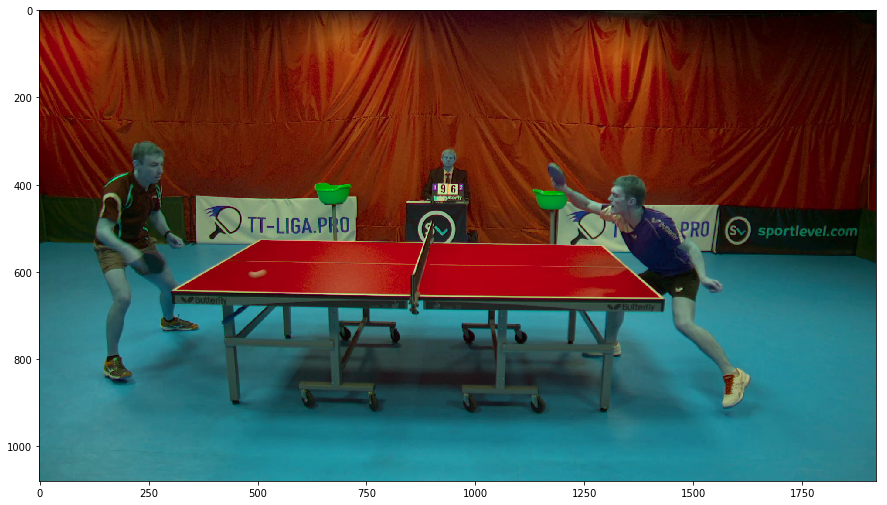

In [10]:
i += 1
print("Current frame: ", i)
tensor = torch.load('/scratch/vr1059/ttnet/game_1/train/{}.pt'.format(i))
plt.imshow(tensor.permute(1, 2, 0))

In [48]:
tensor.shape

torch.Size([3, 1080, 1920])

In [49]:
img = transforms.ToPILImage()(tensor)
boom = transforms.Resize((128, 320))(img)
boom = transforms.ToTensor()(boom)

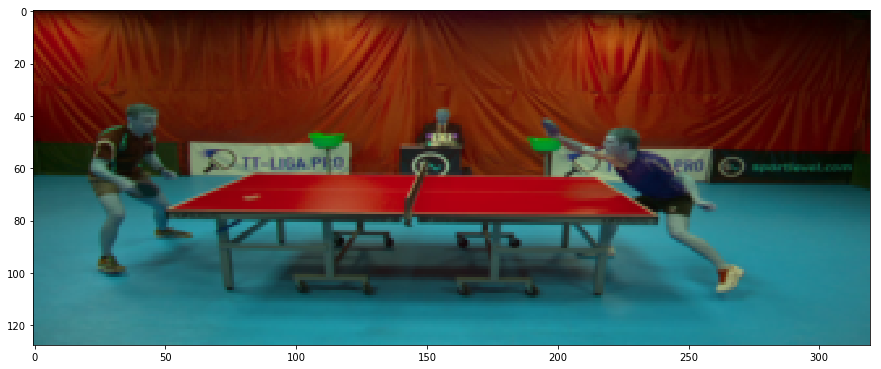

In [50]:
plt.imshow(boom.permute(1, 2, 0))

#### Gaussian

In [57]:
import scipy.stats as stats
import math

In [58]:
matplotlib.rcParams['figure.figsize'] = [8, 8]

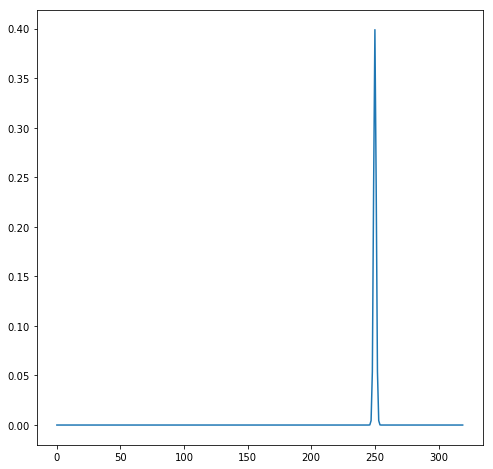

In [65]:
mu = 250
variance = 1
sigma = math.sqrt(variance)
x = np.arange(0, 320)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [69]:
boom = stats.norm.pdf(x, mu, sigma)
boom[boom < 0.02] = 0

In [73]:
len(boom)

320

In [75]:
torch.tensor(boom)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [2]:
with open('/scratch/vr1059/ttnet/game_1/train/label_events.pkl', 'rb') as label:
    label_events = pkl.load(label)

In [3]:
with open('/scratch/vr1059/ttnet/game_1/train/frame_ids.pkl', 'rb') as f:
    frame_ids = pickle.load(f)

In [4]:
with open('/scratch/vr1059/ttnet/game_1/ball_markup.json', 'rb') as f:
    ball_label = json.load(f)

In [5]:
for x in frame_ids:
    if str(x+8) not in ball_label:
        print(label_events[x])
        print(x+8)

#### quick dataset check

In [3]:
train_ds = FrameDataset(phase='train', root_dir='/scratch/vr1059/ttnet/game_1/')
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

In [4]:
hi_frames, lo_frames, event_label, ball_label, global_x, global_y, start, middle = iter(train_dl).next()

In [12]:
lo_frames.shape

torch.Size([1, 9, 3, 128, 320])

In [5]:
event_label

tensor([[0.9200, 0.0000]])

In [6]:
ball_label

tensor([[1322,  517]])

In [7]:
print(torch.argmax(global_x), torch.argmax(global_y))

tensor(220) tensor(61)


In [8]:
print(start, middle)

tensor([72473]) tensor([72477])


### model

In [18]:
class ConvBlock(nn.Module):
    def __init__(self, a, b):
        super(ConvBlock, self).__init__()
        
        self.layers = [
            nn.Conv2d(a, b, (3, 3), stride=1, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2)
        ]
        
        self.model = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.model(x)
        

class BallDetect(nn.Module):
    def __init__(self):
        super(BallDetect, self).__init__()
        
        self.encoder_list = [
            nn.Conv2d(27, 64, (1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            ConvBlock(64, 64),
            ConvBlock(64, 64),
            nn.Dropout2d(),
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.Dropout2d(),
            ConvBlock(128, 256),            
            ConvBlock(256, 256)
        ]
        
        self.fc_list = [
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(2560, 1792),
            nn.ReLU(),
            nn.Dropout(), 
        ]
        
        self.x_list = [
            nn.Linear(1792, 640),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.Sigmoid()
        ]
        
        self.y_list = [
            nn.Linear(1792, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.Sigmoid()
        ]
        
        self.encoder = nn.Sequential(*self.encoder_list)
        self.fc_branch = nn.Sequential(*self.fc_list)
        self.x = nn.Sequential(*self.x_list)
        self.y = nn.Sequential(*self.y_list)
        
    def forward(self, x):
        features = self.encoder(x)
        
        shared = self.fc_branch(features)
        
        x_coord = self.x(shared)
        y_coord = self.y(shared)
        
        return features, x_coord, y_coord

In [27]:
global_det = BallDetect()
local_det = BallDetect()
criterion = nn.BCELoss()

In [28]:
train_ds = FrameDataset(phase='train', root_dir='/scratch/vr1059/ttnet/game_1/')
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)


Ohhhh I finally get why the input to their model has to have 27 channels. 
It's because they combine 9*3 to get 27. I got it. 


In [31]:
for i, batch in enumerate(train_dl):
    pdb.set_trace()
    
    hi_frames, lo_frames, event_label, ball_label, g_xtarget, g_ytarget, start, middle = batch
    
    # [0] below is because batchsize=1
    lo_frames = lo_frames.view(1, -1, 128, 320).transpose(2, 3)
    hi_frames = hi_frames.view(1, -1, 1080, 1920).transpose(2, 3)
    
    g_feats, g_x, g_y = global_det(lo_frames)
    
    # Treating this as multi-class classification
    # (g_x, g_y) are global coordinates 
    g_loss = criterion(g_x, g_xtarget.float()) + criterion(g_y, g_ytarget.float())
    
    # todo: crop hi-res image using center
    
    

> <ipython-input-31-9b84ef17781e>(4)<module>()
-> hi_frames, lo_frames, event_label, ball_label, g_xtarget, g_ytarget, start, middle = batch
(Pdb) n
> <ipython-input-31-9b84ef17781e>(7)<module>()
-> lo_frames = lo_frames.view(1, -1, 128, 320).transpose(2, 3)
(Pdb) n
> <ipython-input-31-9b84ef17781e>(8)<module>()
-> hi_frames = hi_frames.view(1, -1, 1080, 1920).transpose(2, 3)
(Pdb) n
> <ipython-input-31-9b84ef17781e>(10)<module>()
-> g_feats, g_x, g_y = global_det(lo_frames)
(Pdb) n
> <ipython-input-31-9b84ef17781e>(15)<module>()
-> g_loss = criterion(g_x, g_xtarget.float()) + criterion(g_y, g_ytarget.float())
(Pdb) n
> <ipython-input-31-9b84ef17781e>(1)<module>()
-> for i, batch in enumerate(train_dl):
(Pdb) g_loss
tensor(1.3724, grad_fn=<AddBackward0>)
(Pdb) q


BdbQuit: 

#### Crop

In [2]:
tensor = torch.load('/scratch/vr1059/ttnet/game_1/train/44.pt')
tensor.shape

torch.Size([3, 1080, 1920])

In [3]:
# TODO: Normalize images to 0-1 (currently from 0-255). 

In [4]:
'''
aite so i have (x, y). 
that's the center. 
I need to extract a 320 by 128 window. 
There's a few cases: 
    - perfect. in the middle. 
'''

def crop(x, y, tensor):
    '''
    Assumes tensor is of the shape ((1, 3, 1920, 1080))
    '''
    left = 0 if x < 160 else x-160
    right = 1920 if (1920 - x) < 160 else x+160
    top = 0 if y < 64 else y-64
    bottom = 1080 if (1080 - y) < 64 else y+64
    
#     pdb.set_trace()
    sample = torch.zeros((1, 3, 320, 128))
    h_left, h_right = 0, 320
    v_top, v_bottom = 0, 128
    if left == 0:
        h_left, h_right = 160-x, 320
    elif right == 1920:
        h_left, h_right = 0, 160 + (1920 - x)
    if top == 0:
        v_top, v_bottom = 64-y, 128
    elif bottom == 1080:
        v_top, v_bottom = 0, 64 + (1080 - y)
                
    sample[:, :, h_left:h_right, v_top:v_bottom] = tensor[:, :, left:right, top:bottom]
    return sample

In [8]:
cropped = crop(400, 600, tensor.permute(0, 2, 1).unsqueeze(0))

In [9]:
cropped.shape

torch.Size([1, 3, 320, 128])

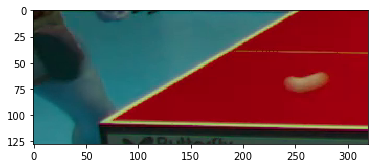

In [10]:
plt.imshow(cropped[0].permute(2, 1, 0).numpy().astype('uint8'))

#### Example

In [17]:
bd = BallDetect()
boom = torch.randn((1, 3, 320, 128))

In [18]:
a, b, c = bd(boom)
for x in [a, b, c]:
    print(x.shape)

torch.Size([1, 256, 5, 2])
torch.Size([1, 320])
torch.Size([1, 128])


In [22]:
ex = torch.randn((1, 3, 2, 5))
print(ex)
print(ex.transpose(2, 3))


tensor([[[[-0.6269,  0.6578,  0.6482,  0.3931,  0.8761],
          [ 1.0263, -0.9038,  0.0843, -1.5202, -1.7352]],

         [[ 0.3096,  0.6709,  0.0723,  1.4136,  0.8451],
          [-0.5792,  0.7425,  0.1133,  1.3100,  0.6654]],

         [[-0.0806,  0.5570, -0.5521,  2.3474,  0.3406],
          [-0.9236,  0.6336, -0.4227, -0.4656, -0.5876]]]])
tensor([[[[-0.6269,  1.0263],
          [ 0.6578, -0.9038],
          [ 0.6482,  0.0843],
          [ 0.3931, -1.5202],
          [ 0.8761, -1.7352]],

         [[ 0.3096, -0.5792],
          [ 0.6709,  0.7425],
          [ 0.0723,  0.1133],
          [ 1.4136,  1.3100],
          [ 0.8451,  0.6654]],

         [[-0.0806, -0.9236],
          [ 0.5570,  0.6336],
          [-0.5521, -0.4227],
          [ 2.3474, -0.4656],
          [ 0.3406, -0.5876]]]])
